## Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

Wrong number of corners in this image


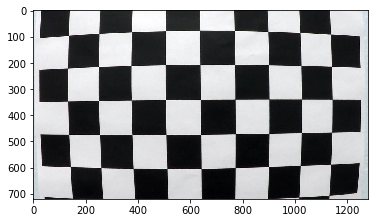

Wrong number of corners in this image


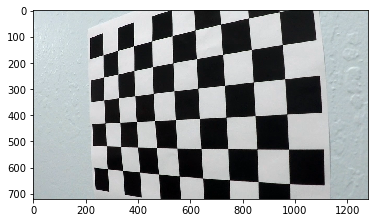

Wrong number of corners in this image


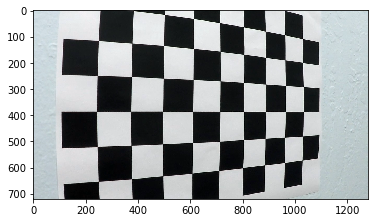

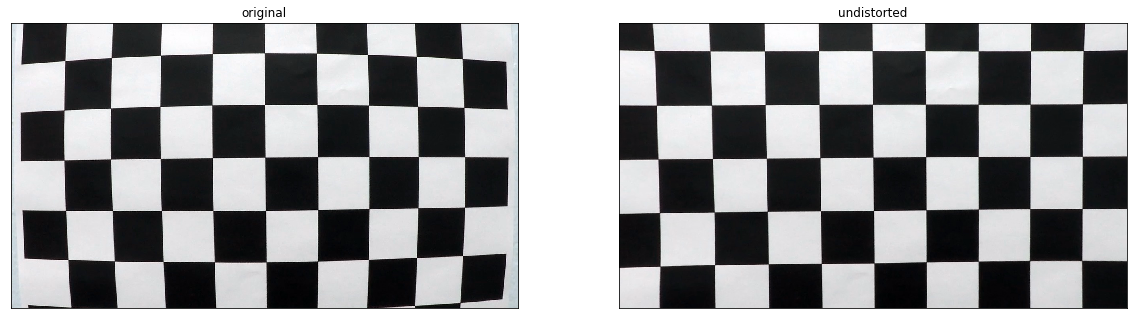

In [6]:
# First of all -> calibrate the camera using the images from "camera_cal"

def draw_corners_and_show(im, nx, ny, corners, ret):
    cv2.drawChessboardCorners(im, (nx, ny), corners, ret)
    plt.imshow(im)
    plt.show()

def show_undistorted(im_list, matrix, dist):
    for i in im_list:
        undistorted = cv2.undistort(i, matrix, dist, None, matrix)
        f, axarr = plt.subplots(1, 2, figsize=(20,10))
        axarr[0].set_title('original')
        axarr[0].xaxis.set_visible(False)
        axarr[0].yaxis.set_visible(False)
        axarr[0].imshow(i)
        axarr[1].set_title('undistorted')
        axarr[1].xaxis.set_visible(False)
        axarr[1].yaxis.set_visible(False)
        axarr[1].imshow(undistorted)
        plt.show()
        
def get_obj_point(im_list, nx, ny):
    '''
    Returns two lists of objpoints and imgpoints used for camera calibration.
    Input is a list of images of chess boards used for calibration and
    the dimension of chess squares intersection in x and y plane.
    '''
    objpoints = []
    imgpoints = []
    #create a '3d coortdinate system' points for the board
    #dimension is nx*ny (num corners) by 3 -> each corner has x,y,z coordinates
    objp = np.zeros((nx*ny, 3), np.float32)
    #create a list of x, y coordinates
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) 
    #Cycle through all images
    for i in im_list:
        corners = np.zeros((nx, ny))
        gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        #finding corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
        #draw the corners and show image
        #draw_corners_and_show(i, nx, ny, corners, ret)
        #check if detected corners are the same number as expected (if one of 
        #the corners can't be seen on the image, we can assign wrong 
        #3D coordinates to found corners)
        if ret == True and len(corners) == nx*ny:
            objpoints.append(objp)
            imgpoints.append(corners)
            #print('OK')
        else:
            print("Wrong number of corners in this image")
            plt.imshow(i)
            plt.show()
    return objpoints, imgpoints
    

cal_images_folder = './camera_cal/'
im_list = []
for i in os.listdir(cal_images_folder):
    im = cv2.imread(os.path.join(cal_images_folder, i))
    #print(im.shape)
    #plt.imshow(im)
    #plt.show()
    im_list.append(im)
    
objpoints, imgpoints = get_obj_point(im_list, 9, 6)
#print(im_list[0].shape[-2::-1])
ret, matrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
             imgpoints, im_list[0].shape[-2::-1], None, None)

#show_undistorted(im_list, matrix, dist)

#save calibration data to pickle so we don't have to run this every time
calibration_data = {"matrix":matrix, "dist":dist}
pickle.dump(calibration_data, open( "calibration.p", "wb" ) )

show_undistorted([im_list[0]], matrix, dist)


In [7]:
# Apply a distortion correction to raw images
      
try:
    len(calibration_data)
except Exception as e:
    calibration_data = pickle.load(open("calibration.p", "rb" ))

matrix = calibration_data['matrix']
dist = calibration_data['dist']

#test on a road image
im = cv2.imread('./test_images/test4.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

show_undistorted([im], matrix, dist)

NameError: name 'show_undistorted' is not defined

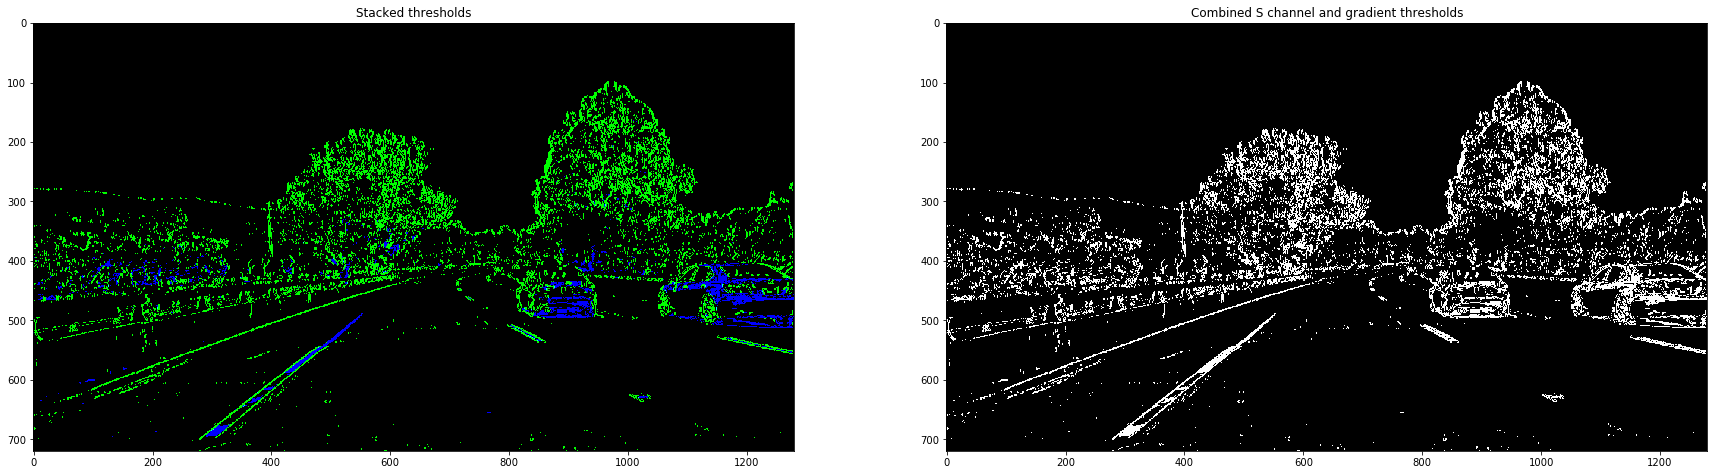

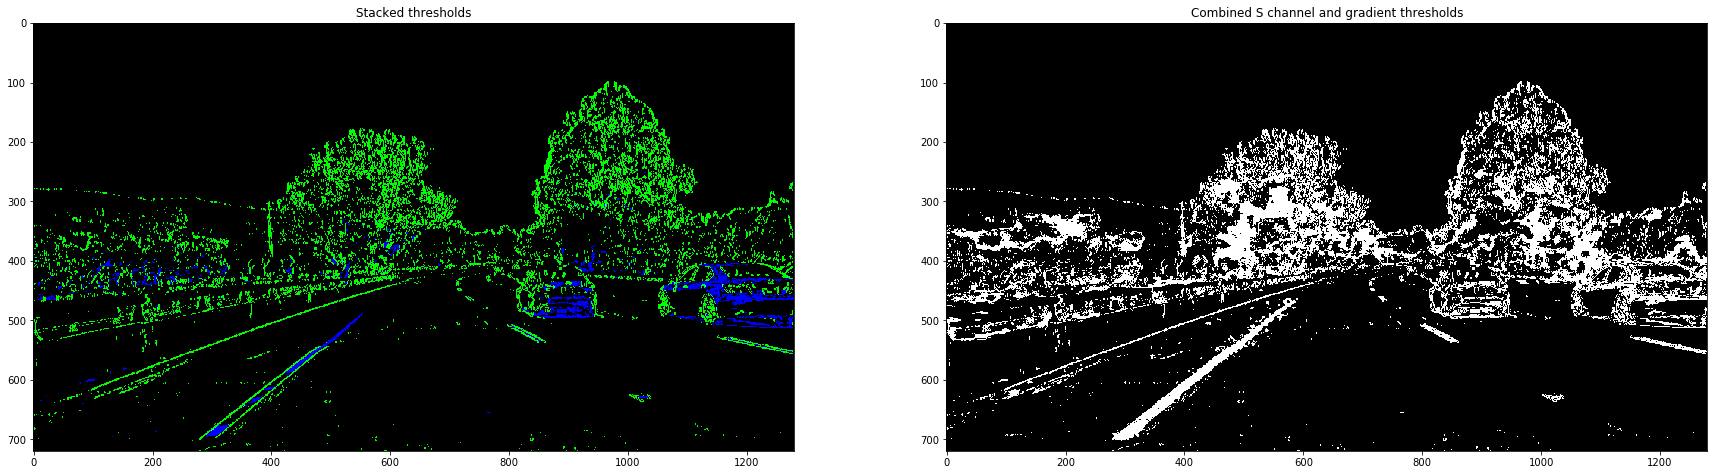

(720, 1280)


In [3]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
# Here I would be reusing the code given in part 30 of "Advanced lane finding"
#test on a road image
im = cv2.imread('./test_images/test4.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.undistort(im, matrix, dist, None, matrix)

def show_binary_combination(sxbinary, s_binary, combined_binary):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,20))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')

    plt.show()

def get_binary(im, separate_yellow_detection=True, show_plots=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = hls[:,:,1]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    # Here I am using the default threshold values
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    # here I am concerned only with detecting white lines, so I can increase the minimum
    # threshhold value to 230
    s_thresh_min = 230
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    
    # Threshold by Hue channel
    # This is done to reduce the lighting range for white (less false positives)
    # and to increase detection of yellow lines which have a lower S value
    # Unfortunately this would increase the processing time by about 50% 
    # as the array should be checked one more time, and can be considered if
    # execution time is important.
    if separate_yellow_detection:
        h_channel = hls[:,:,0]
        h_thresh_min = 18
        h_thresh_max = 22
        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
        combined_binary[(s_binary == 1) | (sxbinary == 1) | (h_binary == 1)] = 1
    else:
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    if show_plots:
        show_binary_combination(sxbinary, s_binary, combined_binary)
    
    return combined_binary
    
binary = get_binary(im, separate_yellow_detection=False, show_plots=True)
binary = get_binary(im, separate_yellow_detection=True, show_plots=True)
print(binary.shape)



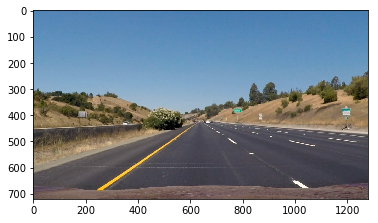

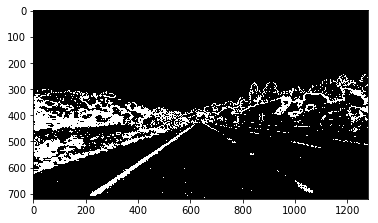

(720, 1280)


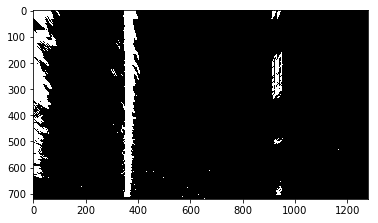

In [7]:
#Apply a perspective transform to rectify binary image ("birds-eye view").

im = cv2.imread('./test_images/straight_lines1.jpg')
#im = cv2.imread('./test_images/test2.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()
undistort = cv2.undistort(im, matrix, dist, None, matrix)
binary = get_binary(undistort, separate_yellow_detection=True)
plt.imshow(binary, cmap='gray')
plt.show()

def get_perspective_transform_matrix(im):
    x_size = im.shape[1]
    y_size = im.shape[0]
    src = np.float32([[0.16*x_size, y_size],
                         [0.5*x_size-82, 0.66*y_size],
                         [0.5*x_size+82, 0.66*y_size],
                         [0.84*x_size, y_size]])

    dst = np.float32([[0.28*x_size, y_size],
                         [0.28*x_size, 0],
                         [0.72*x_size, 0],
                         [0.72*x_size, y_size]])
    M = cv2.getPerspectiveTransform(src, dst)
    return M

M = get_perspective_transform_matrix(binary)
warped = cv2.warpPerspective(binary, M, (binary.shape[1], binary.shape[0]), flags=cv2.INTER_LINEAR)
print(warped.shape)

plt.imshow(warped, cmap='gray')
plt.show()



In [4]:
#Determine the curvature of the lane and vehicle position with respect to center.
class Line():
    def __init__(self, y_size, xm_per_pix=0.0062, ym_per_pix=0.035):
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        self.y_size = y_size
        self.ploty = np.linspace(0, self.y_size-1, self.y_size)
        self.detected = False
        self.x_idxs = None
        self.y_idxs = None
        self.fit = None
        self.fitx = None
        self.curvature = None
        
    def update(self, x_idxs, y_idxs):
        if len(x_idxs) > 0:
            self.x_idxs = x_idxs
            self.y_idxs = y_idxs
            self.fit = np.polyfit(y_idxs, x_idxs, 2)
            if self.detected == True:
                self.fitx = 0.8*self.fitx + 0.2*self.fit2fitx()
                self.curvature = 0.8*self.curvature + 0.2*min(self.compute_curvature(), 3000)
            else:
                self.fitx = self.fit2fitx()
                self.curvature = min(self.compute_curvature(), 3000)
            self.detected = True
        else:
            self.detected = False       
        
    def fit2fitx(self):
        fitx = self.fit[0]*self.ploty**2 + self.fit[1]*self.ploty + self.fit[2]
        return fitx
        
    def compute_curvature(self):
        # Define conversions in x and y from pixels space to meters
        y_eval = self.y_size - 1
        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(self.ploty*self.ym_per_pix, self.fitx*self.xm_per_pix, 2)
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        # Now our radius of curvature is in meters
        return curverad
    
    def is_parallel_to(self, line2, min_limit_diff=500, max_limit_diff=700, limit_diff=100):
        max_diff = np.max(np.absolute(self.fitx - line2.fitx))
        min_diff = np.min(np.absolute(self.fitx - line2.fitx))                  
        parallel = (max_diff < max_limit_diff and
                    min_diff > min_limit_diff and
                    max_diff - min_diff < limit_diff)
        if not parallel:
            print (np.min(np.absolute(self.fitx - line2.fitx)), np.max(np.absolute(self.fitx - line2.fitx)))
        return parallel
    
    def copy(self):
        return deepcopy(self)
    
    
#Reusing some of the code from 33. Finding the Lines
def find_warped_lines(warped):
    # Assuming you have created a warped binary image called "binary_warped"
    x_size = warped.shape[1]
    y_size = warped.shape[0]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[y_size//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = None

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(y_size/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = y_size - (window+1)*window_height
        win_y_high = y_size - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #print(window, (win_xleft_low,win_y_low),(win_xleft_high,win_y_high))

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
       
    return leftx, lefty, rightx, righty

def fit_warped_lines(warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty



#left_fit = np.polyfit(lefty, leftx, 2)


def fit2fitx(fit, y_size):
    ploty = np.linspace(0, y_size-1, y_size )
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return left_fitx

def compute_curvature(left_fit, right_fit, y_size, xm_per_pix = 0.0062, ym_per_pix = 0.042):
    # Define conversions in x and y from pixels space to meters
    left_fitx, right_fitx, ploty = fit2fitx(left_fit, right_fit, y_size)
    
    y_eval = y_size - 1
    # Fit new polynomials to x,y in world space
    #print(ploty.shape, left_fitx.shape)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

# Warp the detected lane boundaries back onto the original image.
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
# Create an image to draw the lines on
def draw_lane(left_fitx, right_fitx, M, warped_size, image_size):
    Minv = np.linalg.inv(M)
    
    ploty = np.linspace(0, image_size[0]-1, image_size[0])
    warp_zero = np.zeros(warped_size).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_size[1], image_size[0])) 
    
    return newwarp

# add current curvature and distance from centre
def add_text(img, x_pos, y_pos, left_fitx, left_curverad, right_fitx, right_curverad, xm_per_pix, ym_per_pix):
    #left_curverad, right_curverad = compute_curvature(left_fit, right_fit, img.shape[0], xm_per_pix, ym_per_pix)
    text_curverad_mean = str(round((left_curverad+right_curverad)/2, 2))+ " m radius"
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    off_center = round((((right_fitx[-1] + left_fitx[-1])-1280)/2)*xm_per_pix, 2)
    if off_center < 0:
        off_center = -off_center
        position = "right"
    else:
        position = "left"
    text_off_center = str(off_center) + " m to the " + position
    cv2.putText(img, text_curverad_mean, (x_pos, y_pos), cv2.FONT_HERSHEY_PLAIN, 4, (255, 255, 255), thickness=4)
    cv2.putText(img, text_off_center, (x_pos, y_pos+100), cv2.FONT_HERSHEY_PLAIN, 4, (255, 255, 255), thickness=4)
    return img

y_size = warped.shape[0]
left_line = Line(y_size)
right_line = Line(y_size)

if left_line.detected == False:
    leftx, lefty, rightx, righty = find_warped_lines(warped)
else:
    leftx, lefty, rightx, righty = fit_warped_lines(warped, left_line.fit, right_line.fit)

left_line.update(leftx, lefty)
right_line.update(rightx, righty)

#test code works for dwetected line
leftx, lefty, rightx, righty = fit_warped_lines(warped, left_line.fit, right_line.fit)
left_line.update(leftx, lefty)
right_line.update(rightx, righty)
# Compute curvature

print(left_line.curvature, right_line.curvature, 'mean radius of curvatur:', (left_line.curvature+right_line.curvature)/2)

newwarp = draw_lane(left_line.fitx, right_line.fitx, M, warped.shape, undistort.shape)
# Combine the result with the original image\
result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)

info_text = add_text(result, 100, 100, left_line.fitx, left_line.curvature,
                     right_line.fitx, right_line.curvature, left_line.xm_per_pix, left_line.ym_per_pix)


plt.imshow(info_text)
plt.show()


NameError: name 'warped' is not defined

In [1]:
#full pipeline
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from helper_functions import *

def add_lane(im, left_line, right_line):
    x_size = im.shape[1]
    y_size = im.shape[0]
    undistorted = cv2.undistort(im, matrix, dist, None, matrix)
    binary = get_binary(undistorted, separate_yellow_detection=True)
    M = get_perspective_transform_matrix(binary)
    warped = cv2.warpPerspective(binary, M, (x_size, y_size), flags=cv2.INTER_LINEAR)
    #w = warped*255
    #cv2.imshow('warped', w)
    cv2.waitKey(1)
    if left_line.detected == False:
        leftx, lefty, rightx, righty = find_warped_lines(warped)
    else:
        leftx, lefty, rightx, righty = fit_warped_lines(warped, left_line.fit, right_line.fit)
    ll_old = left_line.copy()
    rl_old = right_line.copy()
    left_line.update(leftx, lefty)
    right_line.update(rightx, righty)
    if not left_line.is_parallel_to(right_line):
        left_line = ll_old
        right_line = rl_old
    
    newwarp = draw_lane(left_line.fitx, right_line.fitx, M, warped.shape, undistorted.shape)
    # Combine the result with the original image\
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    info_text = add_text(result, 100, 100, left_line.fitx, left_line.curvature,
                     right_line.fitx, right_line.curvature, left_line.xm_per_pix, left_line.ym_per_pix)

    return info_text, left_line, right_line

try:
    len(calibration_data)
except Exception as e:
    calibration_data = pickle.load(open("calibration.p", "rb" ))

matrix = calibration_data['matrix']
dist = calibration_data['dist']

def record_video(video, output_video):
    cap = cv2.VideoCapture(video)
    #get fps
    fps = cap.get(cv2.CAP_PROP_FPS)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # get frame size
    # image dimensions
    #x_size = im.shape[1]
    #y_size = im.shape[0]
    x_size = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
    y_size = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
    #print(x_size, y_size, '@', fps)

    # Define the codec and create VideoWriter object
    # h264 not available for ipython on my machine -> 
    # would convert later using moviepy
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video,fourcc, int(fps), (int(x_size), int(y_size)))
    left_line = Line(y_size)
    right_line = Line(y_size)
    counter = 0
    t0 = time.clock()

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frame, left_line, right_line = add_lane(frame, left_line, right_line)
            # write the flipped frame
            if counter%(int(length/10)) == 0:
                print(counter/length, (time.clock()-t0), "seconds")
            counter += 1
            out.write(frame)
        else:
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
record_video("./project_video.mp4", "./output.avi")

0.0 0.2112425902996724 seconds
0.1 17.831842606908225 seconds
0.2 33.770997922064836 seconds
0.3 49.58529471316191 seconds
0.4 65.44832314271132 seconds
496.526386185 601.180995435
498.447272682 600.432675529
505.415574922 610.938198088
504.763368353 614.228618495
498.419244598 604.125985288
498.964332788 600.100778423
504.889317319 609.414190621
477.185505164 584.06012125
460.385856423 586.995464674
420.297247855 579.472717961
416.939628794 586.079191592
439.857815028 595.09038257
376.168366214 594.338123422
357.686168656 599.45577986
485.399111832 601.184942566
453.51215074 597.02982464
479.741541455 594.514289968
466.877434985 599.714657087
604.319425685 719.449014492
596.102560275 710.489668293
606.488319457 710.871703079
603.69808613 710.938679768
602.18473523 711.650703033
600.347863463 708.13924132
599.924893706 705.808551565
600.579661849 707.414114625
599.591866119 707.308486398
595.447198674 705.346093519
586.711799939 702.295911722
594.405815221 707.477274566
591.261134861 7

In [2]:
from moviepy.editor import VideoFileClip
myclip = VideoFileClip("./output.avi")
myclip.write_videofile(("./output.mp4"), audio=False)


[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


100%|█████████████████████████████████████████████████████████▉| 1253/1254 [00:34<00:00, 36.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 



In [3]:
from IPython.display import HTML

HTML("""
<video width="480" height="360" controls>
  <source src="./output.mp4" type="video/mp4">
</video>
""")

In [ ]:
def add_lane(im, left_line, right_line):
    x_size = im.shape[1]
    y_size = im.shape[0]
    undistorted = cv2.undistort(im, matrix, dist, None, matrix)
    binary = get_binary(undistorted, separate_yellow_detection=True)
    M = get_perspective_transform_matrix(binary)
    warped = cv2.warpPerspective(binary, M, (x_size, y_size), flags=cv2.INTER_LINEAR)
    #w = warped*255
    #cv2.imshow('warped', w)
    cv2.waitKey(1)
    if left_line.detected == False:
        leftx, lefty, rightx, righty = find_warped_lines(warped)
    else:
        leftx, lefty, rightx, righty = fit_warped_lines(warped, left_line.fit, right_line.fit)
    ll_old = left_line.copy()
    rl_old = right_line.copy()
    left_line.update(leftx, lefty)
    right_line.update(rightx, righty)
    if not left_line.is_parallel_to(right_line, 300, 550, 250):
        left_line = ll_old
        right_line = rl_old
    
    newwarp = draw_lane(left_line.fitx, right_line.fitx, M, warped.shape, undistorted.shape)
    # Combine the result with the original image\
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    info_text = add_text(result, 100, 100, left_line.fitx, left_line.curvature,
                     right_line.fitx, right_line.curvature, left_line.xm_per_pix, left_line.ym_per_pix)

    return info_text, left_line, right_line

record_video("./challenge_video.mp4", "./challenge_output.avi")

In [ ]:
from moviepy.editor import VideoFileClip
myclip = VideoFileClip("./challenge_output.avi")
myclip.write_videofile(("./challenge_output.mp4"), audio=False)